In [54]:
import os
from pathlib2 import Path

import torch
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from src.data.dataloader import get_loaders_with_concepts
from src.models.utils import load_experiment
from src.models.test import test_model
from src.data.process_dataset import get_meta
from src.evaluation.gradcam import *

In [40]:
plt.style.use('ggplot')
sns.set(font_scale=1.0)
sns.set_style('darkgrid')

In [41]:
BASE_PATH               = Path("../..")
PROCESSED_DATA_PATH     = BASE_PATH / 'data/processed/CUB_processed'
RAW_DATA_PATH           = BASE_PATH / 'data/raw'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
meta = get_meta(RAW_DATA_PATH / 'CUB_200_2011')

idx2label, label2idx = meta['classes'].values()

In [42]:
normalization = {'mean': np.array([0.5, 0.5, 0.5]), 'std': np.array([2.0, 2.0, 2.0])}
# Inverse normalization - reverts from normalized to original image space
invNormalization = transforms.Compose([
    transforms.Normalize(mean=[ 0., 0., 0. ], std=1 / normalization['std']), 
    transforms.Normalize(mean=-normalization['mean'], std = [1., 1., 1.]),
])

In [43]:
raw_datafolder_path = BASE_PATH / 'data/raw'
processed_datafolder_path = BASE_PATH / 'data/processed/CUB_200_2011/bottleneck'

loaders, normalization = get_loaders_with_concepts(
    raw_data_folder=raw_datafolder_path,
    processed_data_folder=processed_datafolder_path,
    batch_size=32,
)

INFO - Loading data...
INFO - training data loaded !
INFO - validation data loaded !
INFO - test data loaded !


In [44]:
experiment_checkpoint   = 'ResNet50-no_freeze-lr1e-4.wd1e-3.bz32.seed0/best.ckpt'

# Define experiment path
experiment_path = BASE_PATH / 'models' / experiment_checkpoint

# Load experiment stored from training
model_name, model, criterion = load_experiment(experiment_path, device=device)
model.eval()

print("")


INFO - LOADED EXPERIMENT: ResNet50-no_freeze-lr1e-4.wd1e-3.bz32.seed0
INFO -  model: {'name': 'ResNet50'}
INFO -  seed: 0
INFO -  best epoch: 24
INFO -  data: 
INFO -    filename: 
INFO -    normalization (mu, sigma): ([0.5, 0.5, 0.5], [2, 2, 2])




x_to_c_path = r"C:\Users\alber\Desktop\DTU\2_HCAI\ResponsibleAI\projects\xai\XAI-ResponsibleAI\models\CBM_independent\independent_image_to_concept_best_model_1.pth"
c_to_y_path = r"C:\Users\alber\Desktop\DTU\2_HCAI\ResponsibleAI\projects\xai\XAI-ResponsibleAI\models\CBM_independent\independent_concept_to_prediction_best_model_1.pth"

x_to_c = torch.load(x_to_c_path)
c_to_y = torch.load(c_to_y_path)

x_to_c.eval()

In [45]:
# Define GradCAM target layer
target_layers = [model.layer4[-1]]
# Define GradCAM model
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())

### Predict on the full test set

In [46]:
# Run test
preds, _, _ = test_model(
    loaders=loaders,
    model=model, 
    criterion=criterion,
    device=device,
)

preds_ = preds.cpu().numpy()

import gc
del preds
gc.collect()

torch.cuda.empty_cache()

INFO - using device: cuda


Predicting on test set...: 100%|██████████| 182/182 [01:04<00:00,  2.81it/s]


--------------------------------------------------------------------------------
PERFORMANCE ON TEST SET
--------------------------------------------------------------------------------
Avg. accuracy (with SEM) =  0.76441 +- 0.00558
--------------------------------------------------------------------------------


### Visualize approach (permutation-based)

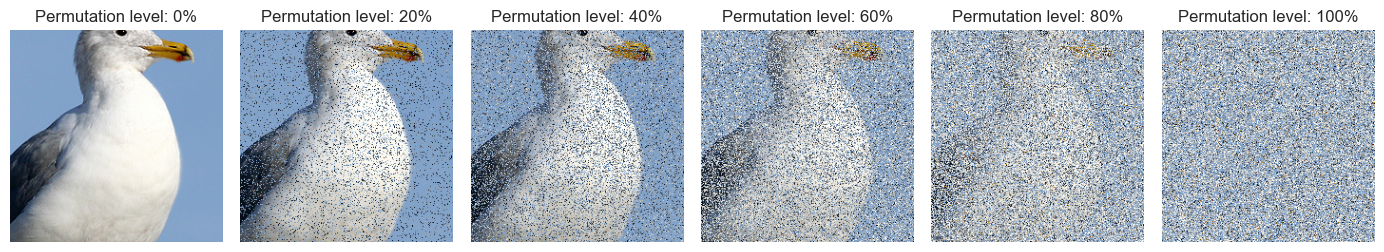

In [75]:
# Select image index to visualize
np.random.seed(0)
# selected_idxs = np.random.choice(len(loaders['test'].dataset), 10, replace=False)
selected_idxs = [1840]
batch = get_vizualisation_batch(loaders, preds_, selected_idxs=selected_idxs)

height, width   = 224, 224
N_pixels        = height * width

fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(14, 5))
for i, frac in enumerate([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]):
    sample_size = int(np.ceil(frac * N_pixels))

    # Create origin and target pixel lists
    original_pixel  = np.arange(height * width)
    target_pixel    = np.random.permutation(original_pixel)


    # Get original and target image
    original_image  = batch['image'][0].numpy()
    target_image    = original_image.copy()

    # Do pixel flipping
    for pixel in range(sample_size):
        target_image[:, target_pixel[pixel] % height, target_pixel[pixel] // width] = original_image[:, original_pixel[pixel] % height, original_pixel[pixel] // width]
    target_image = torch.tensor(target_image)
    
    axs[i].imshow(invNormalization(target_image).permute(1,2,0).numpy())
    axs[i].axis('off')
    axs[i].set_title(f'Permutation level: {frac * 100:.0f}%')

# fig.suptitle('Pixel Flipping')
plt.tight_layout()
plt.show()

### Run experiment on trained models

### Visualizing some example images

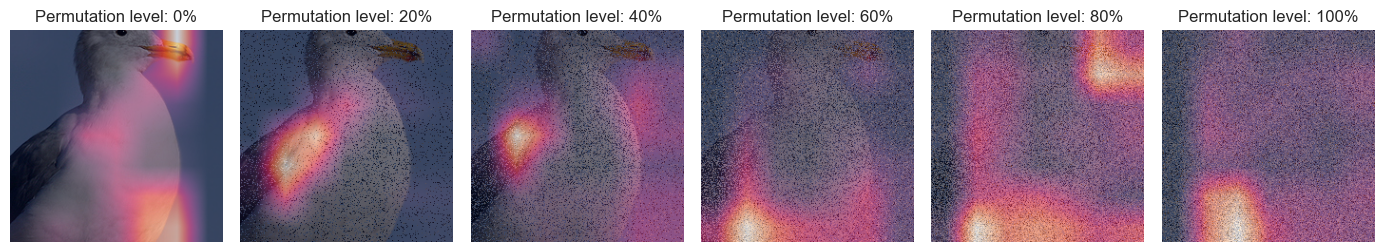

In [91]:
# Select image index to visualize
np.random.seed(0)
selected_idxs = [1840]
batch = get_vizualisation_batch(loaders, preds_, selected_idxs=selected_idxs)

height, width   = 224, 224
N_pixels        = height * width

# Compute saliency maps
CAM_target = 'prediction'
# Initialize an empty dictionary
saliency_maps = {}

pixel_flip_ratios = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
N = len(pixel_flip_ratios)
fig, axs = plt.subplots(1, N, sharex=True, sharey=True, figsize=(14, 5))
for i, frac in enumerate(pixel_flip_ratios):
    sample_size = int(np.ceil(frac * N_pixels))

    # Create origin and target pixel lists
    original_pixel  = np.arange(height * width)
    target_pixel    = np.random.permutation(original_pixel)

    # Setup storage
    batch_ = {'index': batch['index'], 'image': [], 'label': batch['label'], 'prediction': [], 'concepts': batch['concepts']}
    for image_idx in range(selected_idxs.__len__()):
        # Get original and target image
        original_image  = batch['image'][image_idx].numpy()
        target_image    = original_image.copy()

        # Do pixel flipping
        for pixel in range(sample_size):
            target_image[:, target_pixel[pixel] % height, target_pixel[pixel] // width] = original_image[:, original_pixel[pixel] % height, original_pixel[pixel] // width]
        target_image = torch.tensor(target_image)

        output = model(target_image.unsqueeze(0).to(device))
        batch_['image'].append(target_image)
        batch_['prediction'].append(torch.exp(output).topk(1)[1])
        batch_['image'] = torch.stack(batch_['image'])
        permuted_saliency_maps = compute_saliency_maps(batch_, cam=cam, CAM_target=CAM_target)
        
    for idx, grayscale_map in permuted_saliency_maps.items():
        saliency_map = torch.tensor(grayscale_map)

        invNormalization = transforms.Compose([
                transforms.Normalize(mean=[ 0., 0., 0. ], std=1 / normalization['std']), 
                transforms.Normalize(mean=-normalization['mean'], std = [1., 1., 1.]),
        ])

        reverted_img = invNormalization(batch_['image'][0]).permute(1, 2, 0).numpy()
        axs[i].imshow(reverted_img)
        axs[i].imshow(grayscale_map, alpha=0.6)
        axs[i].axis('off')
        axs[i].set_title(f'Permutation level: {frac * 100:.0f}%')

plt.tight_layout()
plt.show()
    

In [ ]:
# Select image index to visualize
np.random.seed(0)
# selected_idxs = np.random.choice(len(loaders['test'].dataset), 10, replace=False)
selected_idxs = [1840]
batch = get_vizualisation_batch(loaders, preds_, selected_idxs=selected_idxs)

height, width   = 224, 224
N_pixels        = height * width

fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(14, 5))
for i, frac in enumerate([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]):
    sample_size = int(np.ceil(frac * N_pixels))

    # Create origin and target pixel lists
    original_pixel  = np.arange(height * width)
    target_pixel    = np.random.permutation(original_pixel)


    # Get original and target image
    original_image  = batch['image'][0].numpy()
    target_image    = original_image.copy()

    # Do pixel flipping
    for pixel in range(sample_size):
        target_image[:, target_pixel[pixel] % height, target_pixel[pixel] // width] = original_image[:, original_pixel[pixel] % height, original_pixel[pixel] // width]
    target_image = torch.tensor(target_image)
    
    axs[i].imshow(invNormalization(target_image).permute(1,2,0).numpy())
    axs[i].axis('off')
    axs[i].set_title(f'Permutation level: {frac * 100:.0f}%')

# fig.suptitle('Pixel Flipping')
plt.tight_layout()
plt.show()

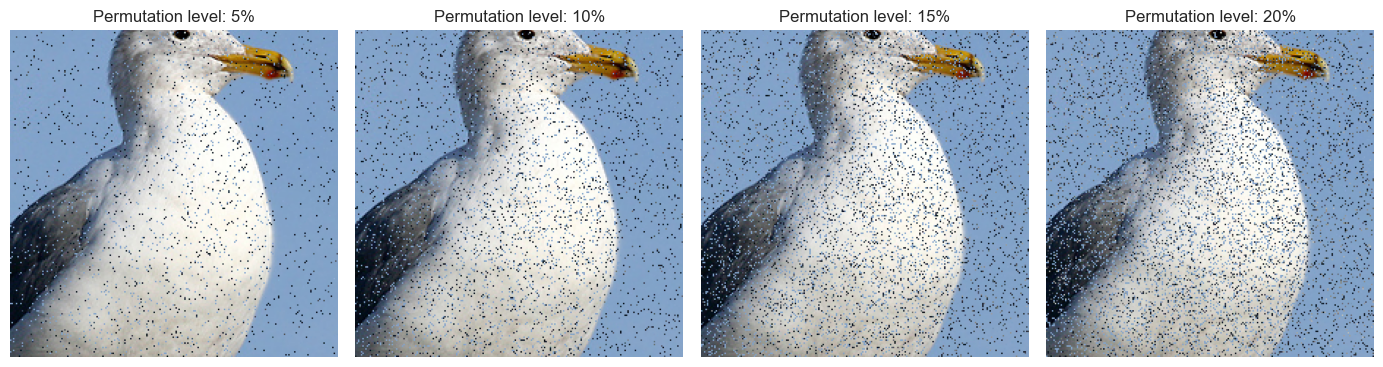

In [93]:
# Select image index to visualize
np.random.seed(0)
# selected_idxs = np.random.choice(len(loaders['test'].dataset), 10, replace=False)
selected_idxs = [1840]
batch = get_vizualisation_batch(loaders, preds_, selected_idxs=selected_idxs)

height, width   = 224, 224
N_pixels        = height * width

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(14, 5))
for i, frac in enumerate([0.05, 0.1, 0.15, 0.2]):
    sample_size = int(np.ceil(frac * N_pixels))

    # Create origin and target pixel lists
    original_pixel  = np.arange(height * width)
    target_pixel    = np.random.permutation(original_pixel)


    # Get original and target image
    original_image  = batch['image'][0].numpy()
    target_image    = original_image.copy()

    # Do pixel flipping
    for pixel in range(sample_size):
        target_image[:, target_pixel[pixel] % height, target_pixel[pixel] // width] = original_image[:, original_pixel[pixel] % height, original_pixel[pixel] // width]
    target_image = torch.tensor(target_image)
    
    axs[i].imshow(invNormalization(target_image).permute(1,2,0).numpy())
    axs[i].axis('off')
    axs[i].set_title(f'Permutation level: {frac * 100:.0f}%')

# fig.suptitle('Pixel Flipping')
plt.tight_layout()
plt.show()

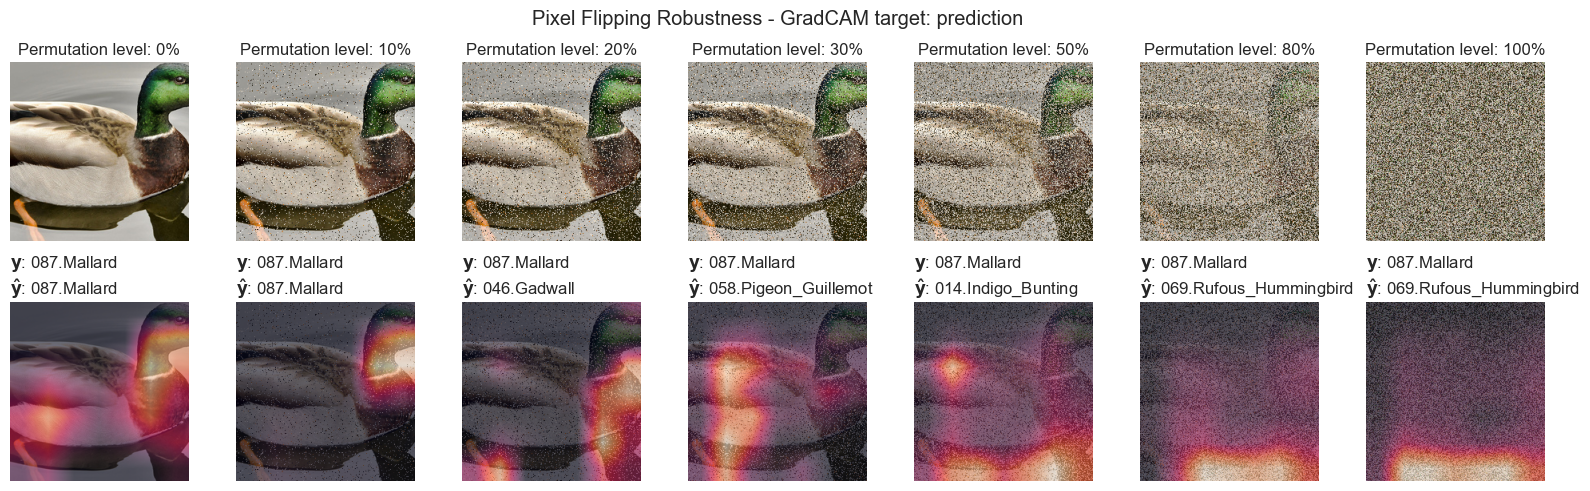

In [235]:
# Select image index to visualize
np.random.seed(0)
# selected_idxs = np.random.choice(len(loaders['test'].dataset), 10, replace=False)
selected_idxs = [2451]
batch = get_vizualisation_batch(loaders, preds_, selected_idxs=selected_idxs)

height, width   = 224, 224
N_pixels        = height * width

CAM_target = 'prediction'
pixel_flip_ratios = [0, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0]
fig, axs = plt.subplots(2, len(pixel_flip_ratios), sharex=True, sharey=True, figsize=(16, 5))
for i, frac in enumerate(pixel_flip_ratios):
    sample_size = int(np.ceil(frac * N_pixels))

    # Create origin and target pixel lists
    original_pixel  = np.arange(height * width)
    target_pixel    = np.random.permutation(original_pixel)


    # Get original and target image
    original_image  = batch['image'][0].numpy()
    target_image    = original_image.copy()

    # Do pixel flipping
    for pixel in range(sample_size):
        target_image[:, target_pixel[pixel] % height, target_pixel[pixel] // width] = original_image[:, original_pixel[pixel] % height, original_pixel[pixel] // width]
    target_image = torch.tensor(target_image)
    
    axs[0][i].imshow(invNormalization(target_image).permute(1,2,0).numpy())
    axs[0][i].axis('off')
    axs[0][i].set_title(f'Permutation level: {frac * 100:.0f}%')

    # SALIENCY MAPS
    batch_ = {'index': batch['index'], 'image': [], 'label': batch['label'], 'prediction': [], 'concepts': batch['concepts']}
    for image_idx in range(selected_idxs.__len__()):
        # Get original and target image
        original_image  = batch['image'][image_idx].numpy()
        target_image    = original_image.copy()

        # Do pixel flipping
        for pixel in range(sample_size):
            target_image[:, target_pixel[pixel] % height, target_pixel[pixel] // width] = original_image[:, original_pixel[pixel] % height, original_pixel[pixel] // width]
        target_image = torch.tensor(target_image)

        output = model(target_image.unsqueeze(0).to(device))
        batch_['image'].append(target_image)
        batch_['prediction'].append(torch.exp(output).topk(1)[1])
        batch_['image'] = torch.stack(batch_['image'])
        permuted_saliency_maps = compute_saliency_maps(batch_, cam=cam, CAM_target=CAM_target)
        
    for idx, grayscale_map in permuted_saliency_maps.items():
        saliency_map = torch.tensor(grayscale_map)

        invNormalization = transforms.Compose([
                transforms.Normalize(mean=[ 0., 0., 0. ], std=1 / normalization['std']), 
                transforms.Normalize(mean=-normalization['mean'], std = [1., 1., 1.]),
        ])

        reverted_img = invNormalization(batch_['image'][0]).permute(1, 2, 0).numpy()
        axs[1][i].imshow(reverted_img)
        axs[1][i].imshow(grayscale_map, alpha=0.6)
        axs[1][i].set_title("\n$\mathbf{y}$: " + 
         f"{meta['classes']['idx2label'][batch_['label'].item()]}" + "\n$\mathbf{\hat{y}}$: " f"{meta['classes']['idx2label'][batch_['prediction'][0].item()]}", loc='left')
        
        axs[1][i].axis('off')

fig.suptitle(f'Pixel Flipping Robustness - GradCAM target: {CAM_target}')
        
        

# fig.suptitle('Pixel Flipping')
plt.tight_layout()
plt.show()
fig.savefig(r'C:\Users\carol\XAI-ResponsibleAI\figures\data_processing\pixel_flipping_w_saliency_maps_2451_mallard.png')

In [ ]:
for i in range(len(loaders['test'].dataset)):
    if loaders['test'].dataset.__getitem__(i)

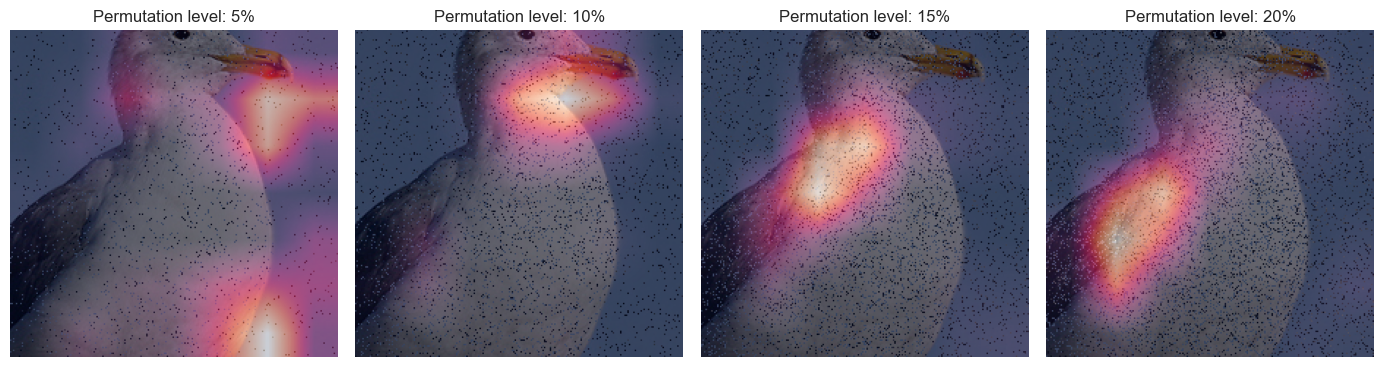

In [94]:
# Select image index to visualize
np.random.seed(0)
selected_idxs = [1840]
batch = get_vizualisation_batch(loaders, preds_, selected_idxs=selected_idxs)

height, width   = 224, 224
N_pixels        = height * width

# Compute saliency maps
CAM_target = 'prediction'
# Initialize an empty dictionary
saliency_maps = {}

pixel_flip_ratios = [0.05, 0.1, 0.15, 0.2]
N = len(pixel_flip_ratios)
fig, axs = plt.subplots(1, N, sharex=True, sharey=True, figsize=(14, 5))
for i, frac in enumerate(pixel_flip_ratios):
    sample_size = int(np.ceil(frac * N_pixels))

    # Create origin and target pixel lists
    original_pixel  = np.arange(height * width)
    target_pixel    = np.random.permutation(original_pixel)

    # Setup storage
    batch_ = {'index': batch['index'], 'image': [], 'label': batch['label'], 'prediction': [], 'concepts': batch['concepts']}
    for image_idx in range(selected_idxs.__len__()):
        # Get original and target image
        original_image  = batch['image'][image_idx].numpy()
        target_image    = original_image.copy()

        # Do pixel flipping
        for pixel in range(sample_size):
            target_image[:, target_pixel[pixel] % height, target_pixel[pixel] // width] = original_image[:, original_pixel[pixel] % height, original_pixel[pixel] // width]
        target_image = torch.tensor(target_image)

        output = model(target_image.unsqueeze(0).to(device))
        batch_['image'].append(target_image)
        batch_['prediction'].append(torch.exp(output).topk(1)[1])
        batch_['image'] = torch.stack(batch_['image'])
        permuted_saliency_maps = compute_saliency_maps(batch_, cam=cam, CAM_target=CAM_target)
        
    for idx, grayscale_map in permuted_saliency_maps.items():
        saliency_map = torch.tensor(grayscale_map)

        invNormalization = transforms.Compose([
                transforms.Normalize(mean=[ 0., 0., 0. ], std=1 / normalization['std']), 
                transforms.Normalize(mean=-normalization['mean'], std = [1., 1., 1.]),
        ])

        reverted_img = invNormalization(batch_['image'][0]).permute(1, 2, 0).numpy()
        axs[i].imshow(reverted_img)
        axs[i].imshow(grayscale_map, alpha=0.6)
        axs[i].axis('off')
        axs[i].set_title(f'Permutation level: {frac * 100:.0f}%')

plt.tight_layout()
plt.show()
    

C:\Users\carol\AppData\Local\Temp\ipykernel_37288\1587134621.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_image = torch.tensor(rotated_img)


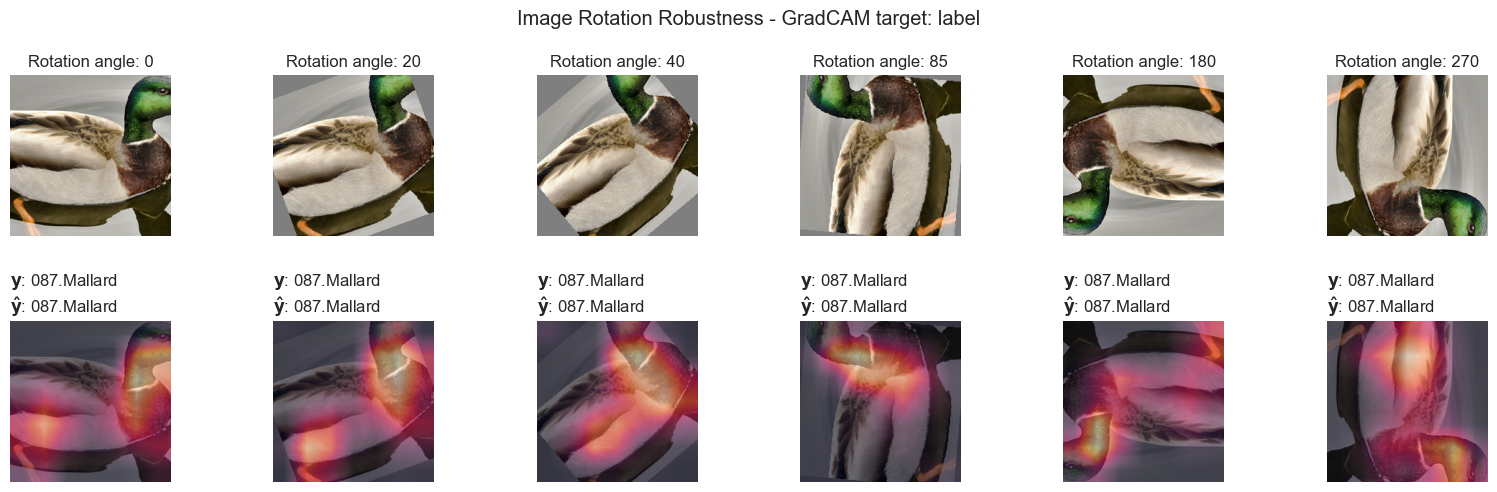

In [234]:
import random
from PIL import Image
import cv2
import torchvision.transforms as transforms

# Select image index to visualize
np.random.seed(0)
# selected_idxs = np.random.choice(len(loaders['test'].dataset), 10, replace=False)
selected_idxs = [2451]
batch = get_vizualisation_batch(loaders, preds_, selected_idxs=selected_idxs)

# Set mean pixel value of your images

CAM_target = 'label'
height, width   = 224, 224
N_pixels        = height * width

rotation_angles = [0, 20, 40, 85, 180, 270]

invNormalization = transforms.Compose([
                transforms.Normalize(mean=[ 0., 0., 0. ], std=1 / normalization['std']), 
                transforms.Normalize(mean=-normalization['mean'], std = [1., 1., 1.]),
        ])

fig, axs = plt.subplots(2, len(rotation_angles), sharex=True, sharey=True, figsize=(16, 5))

mean_pixel_value = np.mean(batch['image'].numpy())
for i, angle in enumerate(rotation_angles):
    batch_ = {'index': batch['index'], 'image': [], 'label': batch['label'], 'prediction': [], 'concepts': batch['concepts']}
    
    for image_idx in range(selected_idxs.__len__()):
        # Get original image
        original_image  = batch['image'][image_idx].numpy()
        img = torch.tensor(original_image)

        rot = transforms.RandomRotation(degrees=(angle, angle+0.001))
        rotated_img = rot(img)
        
        target_image = torch.tensor(rotated_img)
        output = model(target_image.unsqueeze(0).to(device))

        batch_['image'].append(target_image)
        batch_['prediction'].append(torch.exp(output).topk(1)[1])
        batch_['image'] = torch.stack(batch_['image'])
        permuted_saliency_maps = compute_saliency_maps(batch_, cam=cam, CAM_target=CAM_target)

        # Plot rotated image
        axs[0][i].imshow(invNormalization(rotated_img).permute(1, 2, 0).numpy())
        axs[0][i].set_title(f'Rotation angle: {angle}')
        #axs[i].imshow(rotated_img.permute(1, 2, 0).numpy())
        axs[0][i].axis('off')
        
    for idx, grayscale_map in permuted_saliency_maps.items():
        saliency_map = torch.tensor(grayscale_map)

        reverted_img = invNormalization(batch_['image'][0]).permute(1, 2, 0).numpy()
        axs[1][i].imshow(reverted_img)
        axs[1][i].imshow(grayscale_map, alpha=0.6)
        axs[1][i].set_title("\n$\mathbf{y}$: " + 
         f"{meta['classes']['idx2label'][batch_['label'].item()]}" + "\n$\mathbf{\hat{y}}$: " f"{meta['classes']['idx2label'][batch_['prediction'][0].item()]}", loc='left')
        
        axs[1][i].axis('off')
    #axs[0][i].imshow((target_image))
    #axs[0][i].axis('off')
    #axs[0][i].set_title(f'Permutation level: {frac * 100:.0f}%')

fig.suptitle(f'Image Rotation Robustness - GradCAM target: {CAM_target}')
plt.tight_layout()
plt.show()
fig.savefig(r'C:\Users\carol\XAI-ResponsibleAI\figures\data_processing\rotations_w_saliency_maps_2451_mallard.png')
        

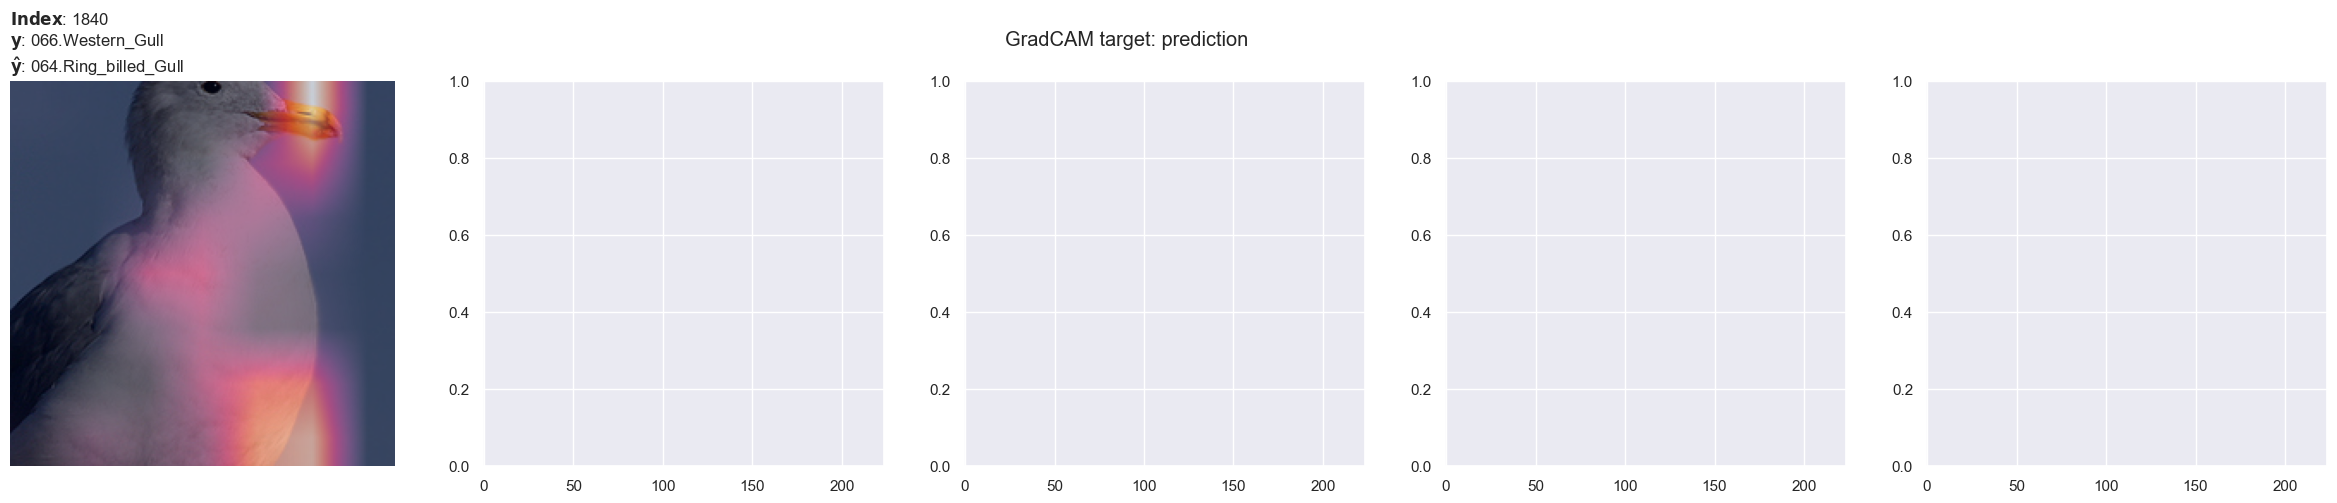

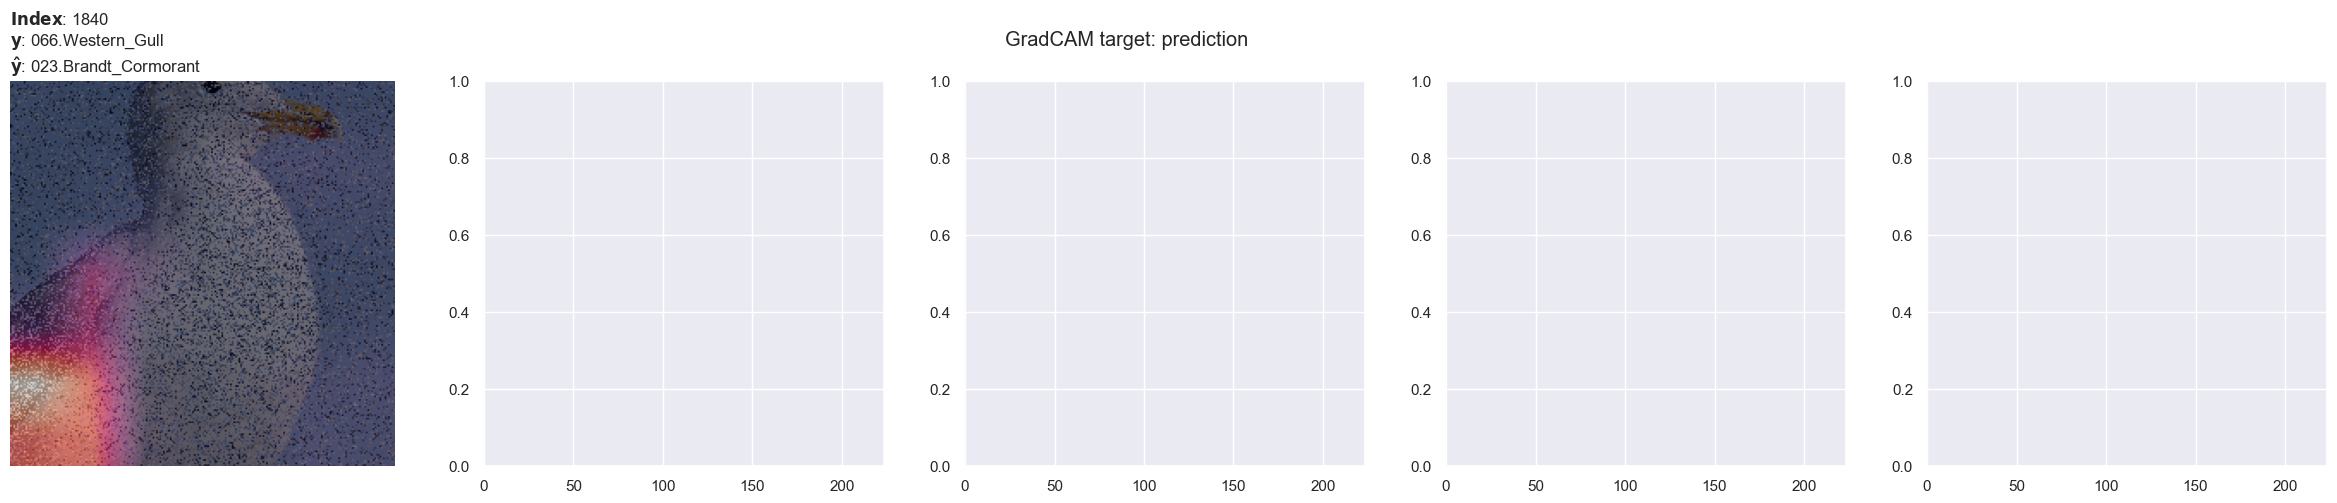

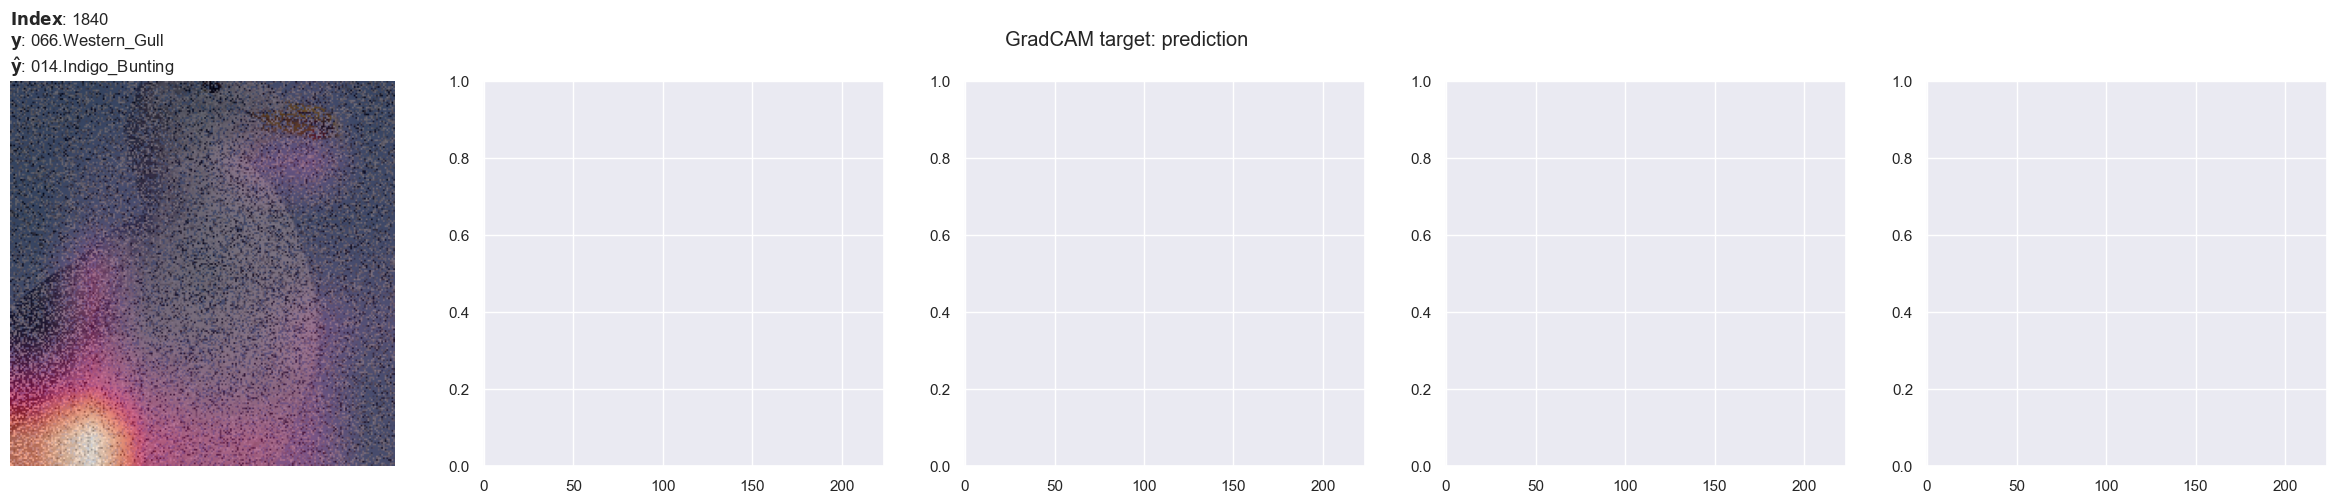

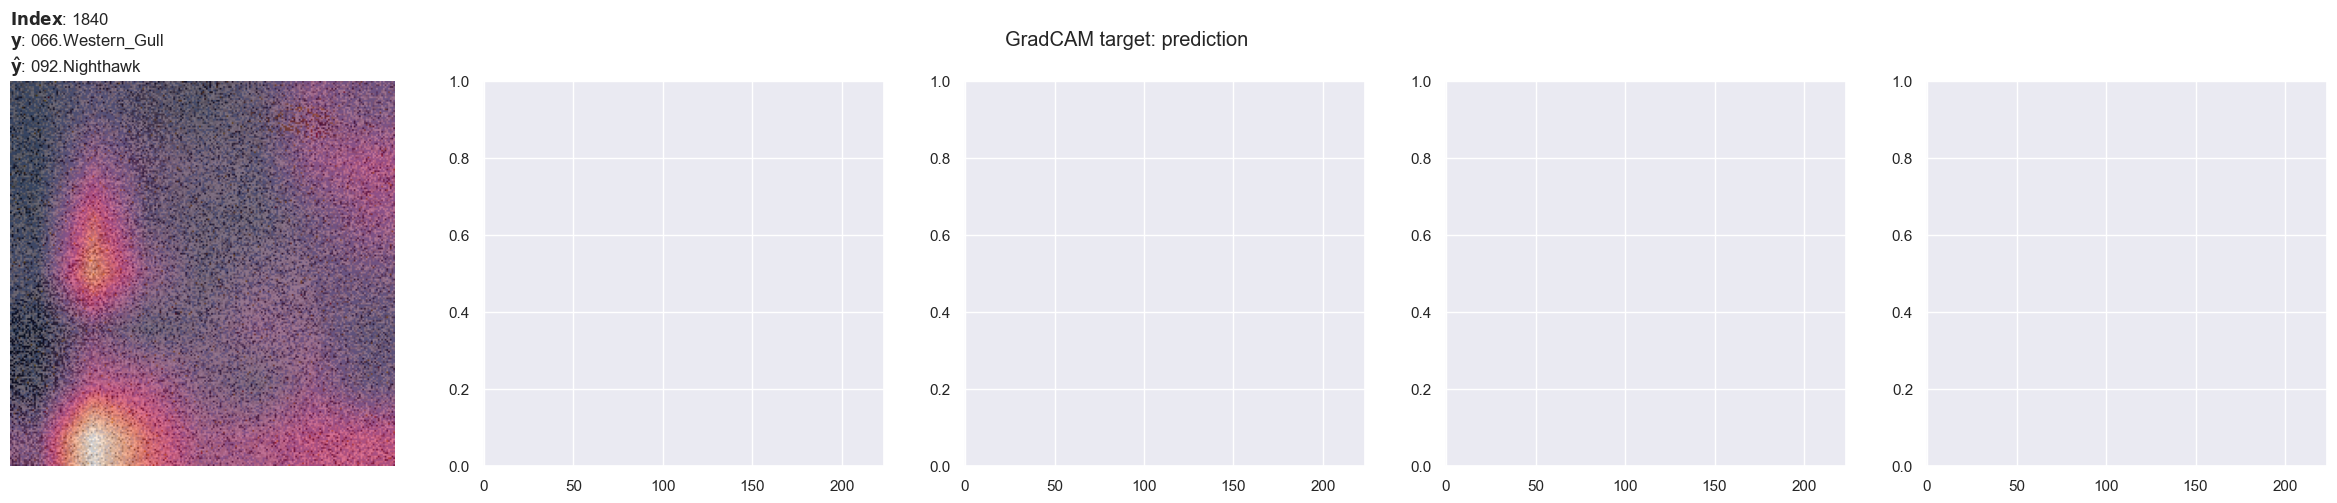

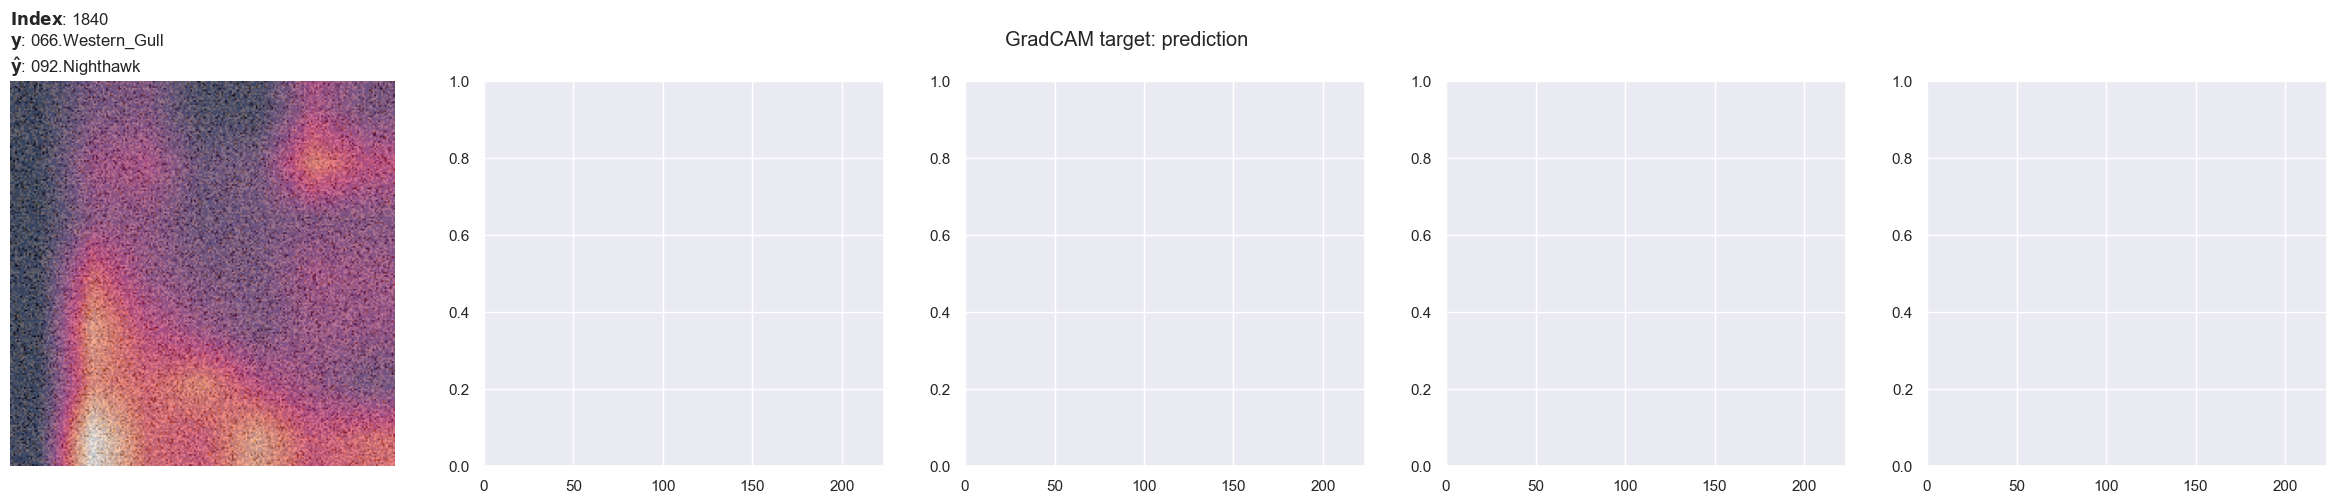

In [29]:
# Select image index to visualize
np.random.seed(0)
selected_idxs = [1840]
batch = get_vizualisation_batch(loaders, preds_, selected_idxs=selected_idxs)

height, width   = 224, 224
N_pixels        = height * width

# Compute saliency maps
CAM_target = 'prediction'

pixel_flip_ratios = [0.0, 0.4, 0.6, 0.8, 1.0]

for i, frac in enumerate(pixel_flip_ratios):
    sample_size = int(np.ceil(frac * N_pixels))

    # Create origin and target pixel lists
    original_pixel  = np.arange(height * width)
    target_pixel    = np.random.permutation(original_pixel)

    # Setup storage
    batch_ = {'index': batch['index'], 'image': [], 'label': batch['label'], 'prediction': [], 'concepts': batch['concepts']}
    for image_idx in range(selected_idxs.__len__()):
        # Get original and target image
        original_image  = batch['image'][image_idx].numpy()
        target_image    = original_image.copy()

        # Do pixel flipping
        for pixel in range(sample_size):
            target_image[:, target_pixel[pixel] % height, target_pixel[pixel] // width] = original_image[:, original_pixel[pixel] % height, original_pixel[pixel] // width]
        
        target_image = torch.tensor(target_image)
        output = model(target_image.unsqueeze(0).to(device))

        batch_['image'].append(target_image)
        batch_['prediction'].append(torch.exp(output).topk(1)[1])

    batch_['image'] = torch.stack(batch_['image'])
    permuted_saliency_maps = compute_saliency_maps(batch_, cam=cam, CAM_target=CAM_target)

    fig = visualize_saliency_maps(permuted_saliency_maps, batch_, normalization, meta=meta, ncols=5, figsize=(30, 5))
    fig.suptitle(f'GradCAM target: {CAM_target}')
    plt.show()